# GPcounts on bulk dataset

Nuha BinTayyash, 2020

This notebook shows how to run [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) R package to normalize [fission yeast](https://bioconductor.org/packages/release/data/experiment/html/fission.html) gene expression data. Then, compare GPcounts with negative binomial likelihood and Gaussian likelihood to find differentially expressed genes in one sample test and two-sample tests.

In [1]:
import numpy as np
import pandas as pd
import gpflow

In [2]:
Y = pd.read_csv('exons_counts.csv',index_col=[0])
X = pd.read_csv('time_points.csv',index_col=[0])
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) 
X

,time
E11_1_F,0.00
E12_1_F,0.08
E13A_1_F,0.16
E13B_1_F,0.24
E14A_1_F,0.40
E14B_1_F,0.52
E14C_1_F,0.64
E14D_1_F,0.76
E14E_1_F,0.88
ECF_1_F,1.00


Fit some fission gene normalized data using GPcounts -- Two samples test

In [4]:
from matplotlib import pyplot as plt
import statsmodels.api as sm

def plot():
    plt.tick_params(labelsize='large', width=2)     
    #plt.ylabel('Gene Expression', fontsize=16)
    #plt.xlabel('Times', fontsize=16)
    c = 'royalblue'
    
    if model_index == 3:
        c = 'green'
    
    plt.plot(xtest, mean,color= c, lw=2) 
    
    if likelihood == 'Gaussian':
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 1*np.sqrt(var[:,0]),
                            mean[:,0] + 1*np.sqrt(var[:,0]),color=c,alpha=0.2) # one standard deviation
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 2*np.sqrt(var[:,0]),
                            mean[:,0] + 2*np.sqrt(var[:,0]),color=c, alpha=0.1)# two standard deviation
    else:
       
        lowess = sm.nonparametric.lowess    
        # one standard deviation 68%
        percentile_16 = lowess(np.percentile(var, 16, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_16 = [(i > 0) * i for i in percentile_16]
        percentile_84 = lowess(np.percentile(var, 84, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_84 = [(i > 0) * i for i in percentile_84]
        plt.fill_between(xtest[:,0],percentile_16,percentile_84,color=c,alpha=0.2)
        
        # two standard deviation 95%
        percentile_5 = lowess(np.percentile(var, 5, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_5 = [(i > 0) * i for i in percentile_5]
        percentile_95 = lowess(np.percentile(var,95, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_95 = [(i > 0) * i for i in percentile_95]
        plt.fill_between(xtest[:,0],percentile_5,percentile_95,color=c,alpha=0.1)
    
    if test == 'Two_samples_test' and model_index == 1:
        plt.scatter(model.data[0][0:int(model.data[0].shape[0]/2)],model.data[1][0:int(model.data[0].shape[0]/2)], s=30, marker='o', color= 'royalblue',alpha=1.) #data    
        plt.scatter(model.data[0][int(model.data[0].shape[0]/2)::],model.data[1][int(model.data[0].shape[0]/2)::], s=30, marker='o', color= 'green',alpha=1.) #data

    else: 
        plt.scatter(model.data[0],model.data[1],s=30,marker = 'o',color=c,alpha=1.)
    
    
    if not(test == 'Two_samples_test' and model_index == 2):
        plt.show()
    

In [5]:
genes_name = [
 'FBgn0003638',
 'FBgn0004237',
 'FBgn0010226',
 'FBgn0010504',
 'FBgn0011888',
 'FBgn0011944',
 'FBgn0011994',
 'FBgn0013679',
 'FBgn0013681',
 'FBgn0013684',
 'FBgn0015791',
 'FBgn0022710']

In [6]:
from GPcounts.GPcounts_Module import Fit_GPcounts
likelihood = 'Negative_binomial' 
gp_counts = Fit_GPcounts(X,Y.loc[genes_name])
log_likelihood_ratio,var_ratio = gp_counts.One_sample_test(likelihood)
log_likelihood_ratio

100%|██████████| 12/12 [00:34<00:00,  2.84s/it]


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio
FBgn0003638,-116.773631,-116.185846,-0.587785
FBgn0004237,-151.659591,-151.621518,-0.038074
FBgn0010226,-157.855277,-156.963726,-0.891551
FBgn0010504,-94.150851,-94.150806,-0.000045
FBgn0011888,-87.025259,-88.574270,1.549011
FBgn0011944,-25.073790,-26.077070,1.003280
FBgn0011994,-18.680481,-21.128352,2.447871
FBgn0013679,-163.349980,-163.349720,-0.000259
FBgn0013681,-94.935694,-97.938336,3.002642
FBgn0013684,-201.103990,-185.350566,-15.753424


100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


FBgn0003638


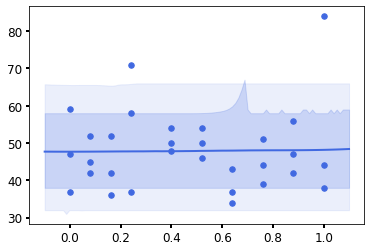

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,43.51464136548643
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,50.04113356048714
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.025259149221562933
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[5.85367059e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[8.65525246e-03, 0.00000000e+00, 0.00000000e+00..."


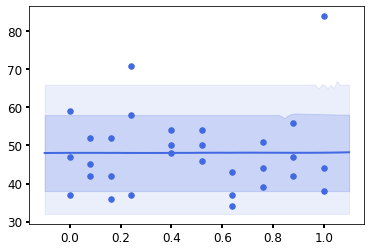

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,14.97754830675785
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,0.025259149221562933
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[1.00002478e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[1.01360497e-02, 0.00000000e+00, 0.00000000e+00..."


FBgn0004237


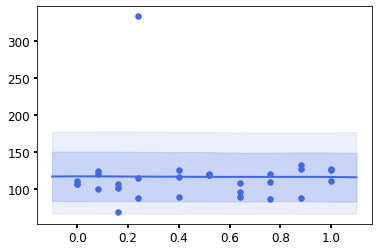

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,19.908176678793627
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,99.51034188823094
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.0761206736346684
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[1.06598828e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[1.27302686e-02, 0.00000000e+00, 0.00000000e+00..."


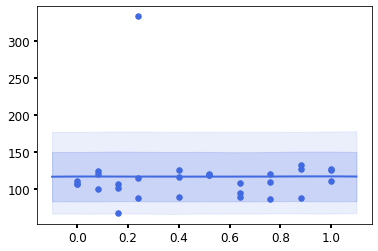

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,22.587568212650005
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,0.0761206736346684
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[1.00043864e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[1.11805963e-02, 0.00000000e+00, 0.00000000e+00..."


FBgn0010226


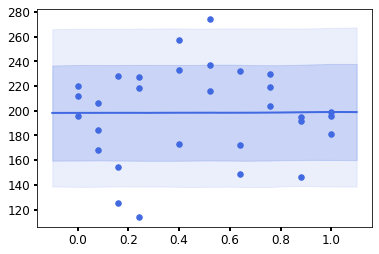

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,81.97044758172004
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,47.14632752086805
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.0338355896707018
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[5.83826042e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[-6.38995492e-03, 0.00000000e+00, 0.00000000e+00..."


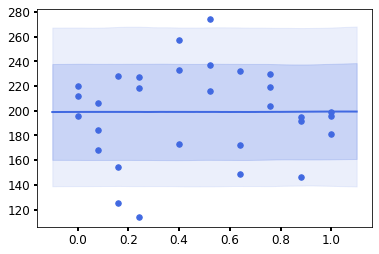

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,28.00405044450648
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,0.0338355896707018
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[9.99900896e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[6.80450250e-03, 0.00000000e+00, 0.00000000e+00..."


FBgn0010504


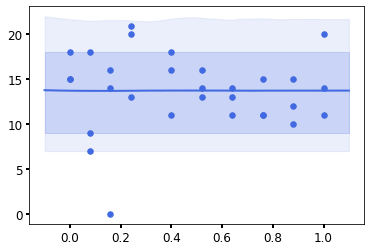

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,6.854858634620423
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1783.321057245922
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.03199159578446351
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[9.98925428e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[2.26152710e-02, 0.00000000e+00, 0.00000000e+00..."


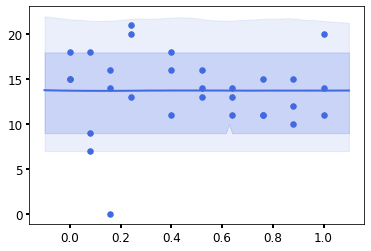

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,6.843519368777542
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,0.03199159578446351
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[9.99756008e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[-2.26247761e-02, 0.00000000e+00, 0.00000000e+00..."


FBgn0011888


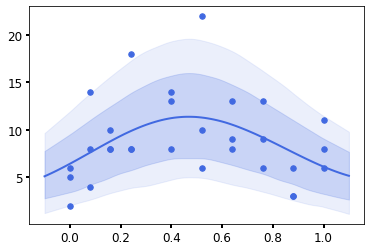

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,2.53699200267536
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.7921177962535719
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.07476820441626164
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[1.15436452e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[1.13070586e-01, 0.00000000e+00, 0.00000000e+00..."


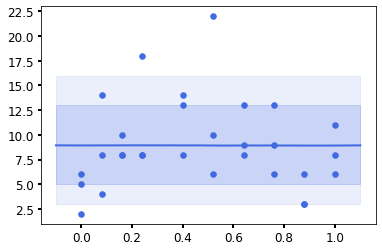

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,4.769805346437421
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,0.07476820441626164
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[9.99346581e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[3.61790385e-02, 0.00000000e+00, 0.00000000e+00..."


FBgn0011944


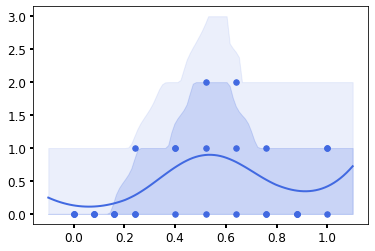

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,2.222773895143892
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.2646538241715426
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,1.5821685020604032e-07
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[-1.54037022e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[5.54514335e-01, 0.00000000e+00, 0.00000000e+00..."


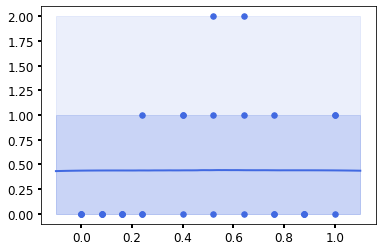

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.8218709316620005
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,1.5821685020604032e-07
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[-9.56420982e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[2.91987775e-01, 0.00000000e+00, 0.00000000e+00..."


FBgn0011994


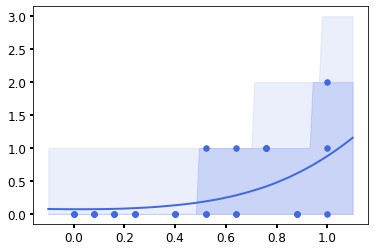

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,5.520649731014384
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.77938557099439
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,9.79518920185421e-08
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[-1.31717491e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[3.95699317e-01, 0.00000000e+00, 0.00000000e+00..."


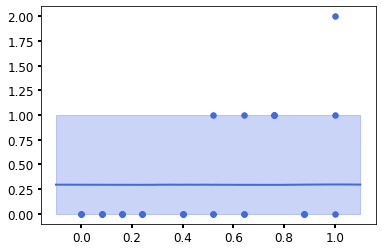

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.767424312343454
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,9.79518920185421e-08
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[-9.69086770e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[2.46724973e-01, 0.00000000e+00, 0.00000000e+00..."


FBgn0013679


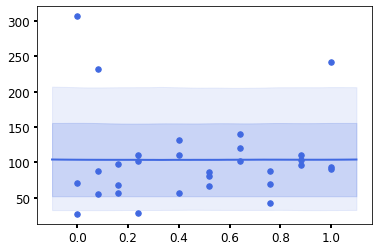

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,21.13566814150108
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,918.5937119138448
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.2678775176439357
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[1.00763279e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[-2.09137360e-02, 0.00000000e+00, 0.00000000e+00..."


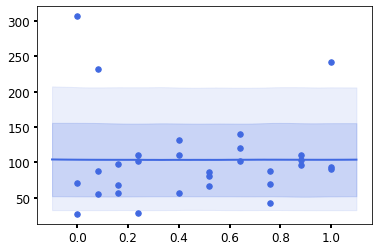

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,21.469865207004823
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,0.2678775176439357
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[9.99768827e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[-2.07414089e-02, 0.00000000e+00, 0.00000000e+00..."


FBgn0013681


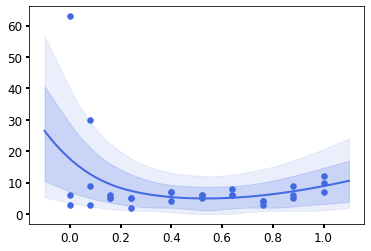

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,8.728949883213362
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.7288496807882664
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.36432293790635684
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[9.55791652e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[8.35989706e-02, 0.00000000e+00, 0.00000000e+00..."


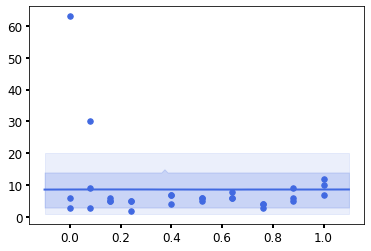

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,4.614884444891728
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,0.36432293790635684
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[9.98277512e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[5.88192748e-02, 0.00000000e+00, 0.00000000e+00..."


FBgn0013684


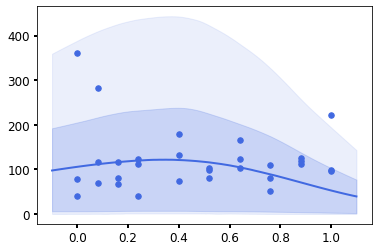

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,2.4254876665730563
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.3751271198577584
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,1.756888142673879
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[2.91277079e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[-3.01555594e-01, 0.00000000e+00, 0.00000000e+00..."


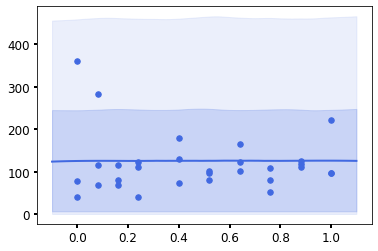

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,23.026812413017144
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,1.756888142673879
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[9.98501493e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[5.01852399e-02, 0.00000000e+00, 0.00000000e+00..."


FBgn0015791


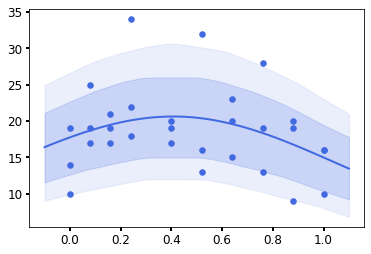

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,4.284233546215999
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.5394657091234938
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.027540046503000872
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[1.38622065e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[5.08363778e-02, 0.00000000e+00, 0.00000000e+00..."


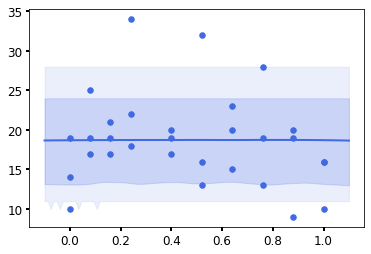

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,8.560738937032465
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,0.027540046503000872
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[9.99830479e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[1.77799354e-02, 0.00000000e+00, 0.00000000e+00..."


FBgn0022710


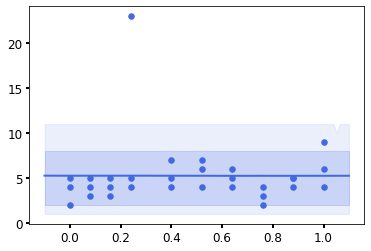

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,2.7311286579405247
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,970.2680740186591
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,0.1312966268635096
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[9.96934088e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[6.27222585e-02, 0.00000000e+00, 0.00000000e+00..."


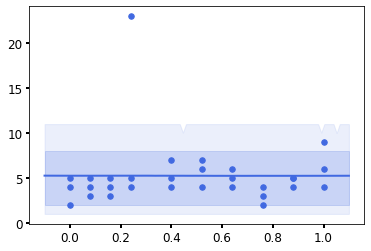

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,2.7251526438264793
VGP.likelihood.alpha,Parameter,Softplus,,False,(),float64,0.1312966268635096
VGP.q_mu,Parameter,,,True,"(30, 1)",float64,[[9.98020976e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 30, 30)",float64,"[[[6.27894986e-02, 0.00000000e+00, 0.00000000e+00..."


In [7]:
indexes = genes_name # list of genes to be plotted 
test = 'One_sample_test' # name of the test
xtest = np.linspace(np.min(X.values)-.1,np.max(X.values)+.1,100)[:,None] # points to make prediction
likelihood = 'Negative_binomial'
params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for mean,var,model in zip(params['means'][i],params['vars'][i],params['models'][i]):
        plot() 
        model_index = model_index + 1
        gpflow.utilities.print_summary(model, fmt='notebook')

In [8]:
likelihood = 'Gaussian'
log_likelihood_ratio,var_ratio = gp_counts.One_sample_test(likelihood)
log_likelihood_ratio

100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio
FBgn0003638,1.230075,1.230142,-6.737394e-05
FBgn0004237,-6.213930,-6.213929,-1.422478e-06
FBgn0010226,0.545552,0.545552,-1.967094e-07
FBgn0010504,-27.521257,-27.521256,-9.150131e-07
FBgn0011888,-21.237937,-22.401008,1.163071e+00
FBgn0011944,-13.544147,-15.100712,1.556565e+00
FBgn0011994,-8.255771,-10.422715,2.166944e+00
FBgn0013679,-27.276890,-27.276792,-9.733341e-05
FBgn0013681,-29.691898,-29.691898,-2.709880e-07
FBgn0013684,-24.708340,-24.708022,-3.182217e-04


100%|██████████| 12/12 [00:00<00:00, 19.91it/s]


FBgn0003638


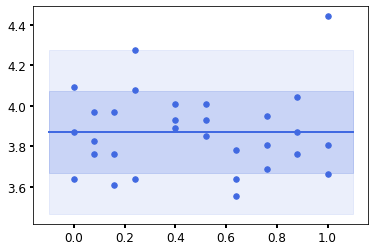

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,14.9725
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,3020.42
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0395102


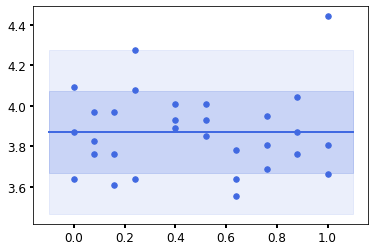

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,14.9833
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.03951


FBgn0004237


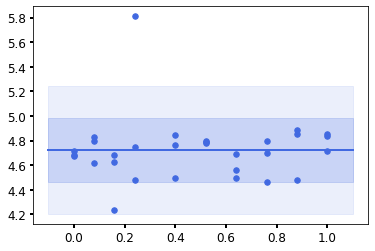

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,22.3075
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,19626.6
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0651189


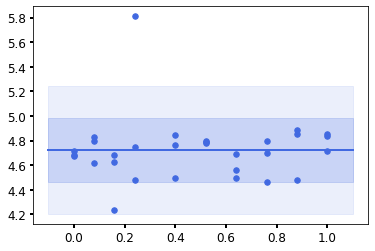

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,22.3011
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0651189


FBgn0010226


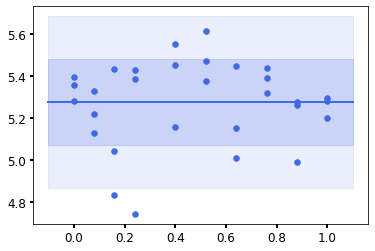

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,27.8522
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,72521
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0405441


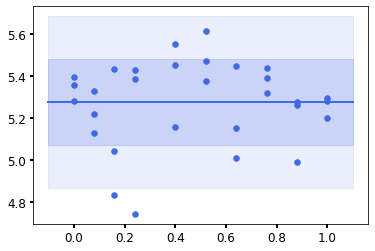

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,27.8522
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0405441


FBgn0010504


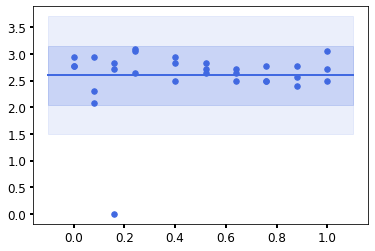

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,6.77132
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,4546.47
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.294933


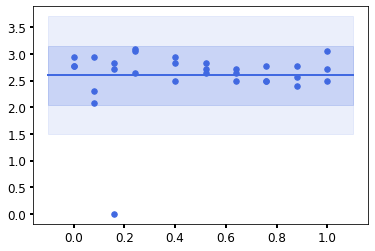

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,6.76278
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.294937


FBgn0011888


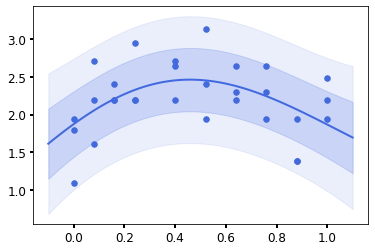

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,2.61812
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.794991
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.16221


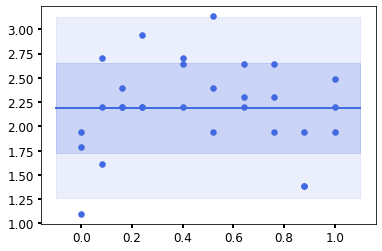

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,4.81525
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.209639


FBgn0011944


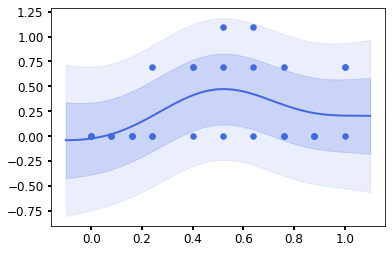

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.0849029
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.26639
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.114979


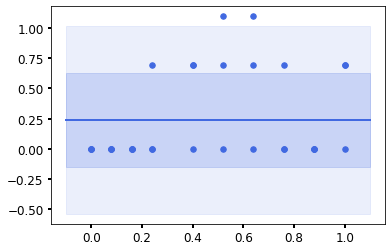

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.0617095
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.146875


FBgn0011994


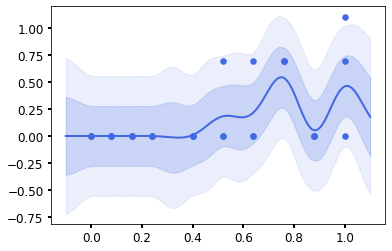

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.0762026
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0696474
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0622566


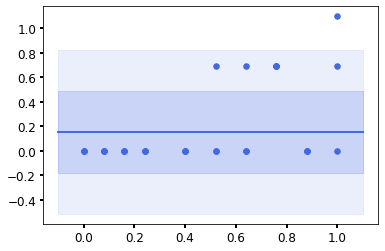

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.0270708
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.109251


FBgn0013679


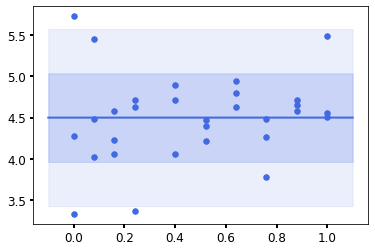

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,20.2612
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,526.741
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.279251


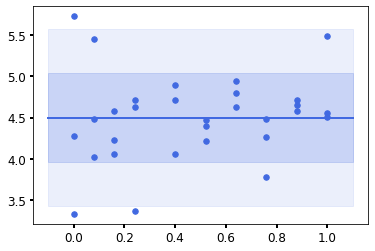

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,20.2633
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.279255


FBgn0013681


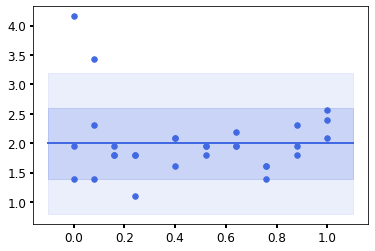

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.99646
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,7875.8
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.348833


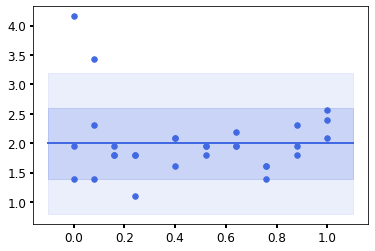

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.99559
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.348832


FBgn0013684


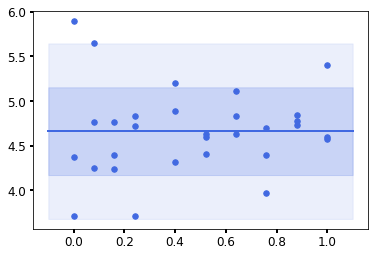

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,21.7446
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,641.562
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.233359


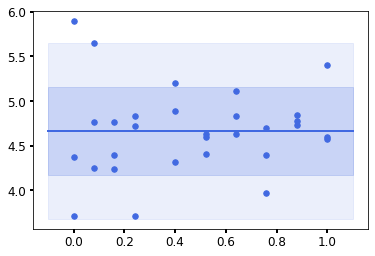

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,21.7339
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.233354


FBgn0015791


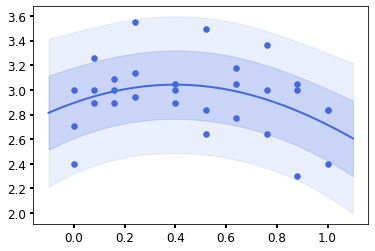

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,4.30587
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.58703
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0729409


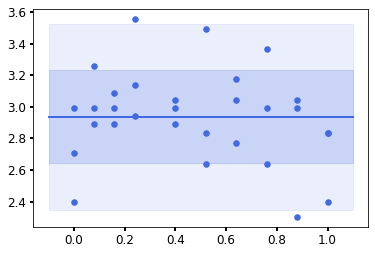

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,8.63335
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0841316


FBgn0022710


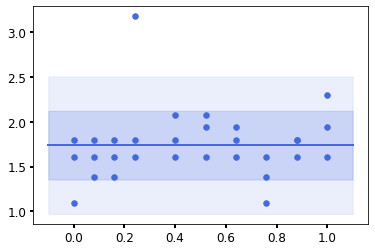

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.0292
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,345.983
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.142484


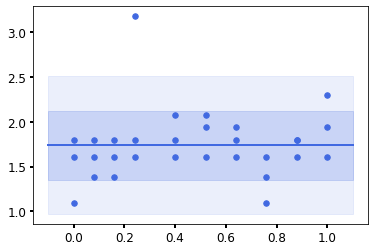

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.03002
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.142482


In [9]:
params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for model,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
        plot()
        model_index = model_index + 1
        gpflow.utilities.print_summary(model, fmt='notebook')